# Experimenting with MCMC chains in tensorflow

This notebook is specifically to focus on how MCMC algorithms get to place where they sample from target probability distributions

In [1]:
import tensorflow as tf

import tensorflow_probability as tfp

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import numpy as np

tfp_d = tfp.distributions

2021-10-11 00:48:35.977116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-11 00:48:35.977139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Preprare probability distribution 

Let the distribution be normal with two distinct peaks

2021-10-11 00:48:37.138682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-11 00:48:37.138702: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-11 00:48:37.138718: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cryo-Latitude-7300): /proc/driver/nvidia/version does not exist
2021-10-11 00:48:37.138934: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


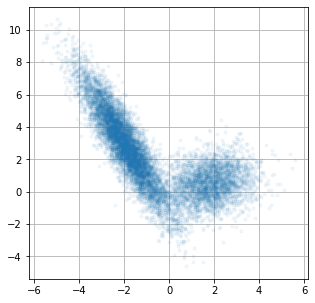

In [2]:
# define two 2d normal distributions
first_dist = tfp_d.MultivariateNormalTriL(
    loc=[1.8, 0.5],
    scale_tril=[[1, np.nan], [0.2, 1]]# the nan one is ignored, since covariance matrix is symmetric
)
#
second_dist = tfp_d.MultivariateNormalTriL(
    loc=[-2.0, 3.0],
    scale_tril=[[1, np.nan], [-2, 1]]# the nan one is ignored, since covariance matrix is symmetric
)
#

# now mix them
mix_share_first = 0.3
#
mix_dist = tfp_d.Mixture(
    cat=tfp_d.Categorical(probs=[mix_share_first, 1.0-mix_share_first]), # mix in equal proportions
    components=[
        first_dist,
        second_dist
    ]
)

sample_points = mix_dist.sample(10000).numpy()

fig, ax = pp.subplots(figsize=(5, 5))
ax.plot(sample_points[:,0], sample_points[:,1], '.', alpha=0.05)
ax.grid()

## Run MCMC to sample from probability distribution

In [3]:
rwm_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=lambda *args: mix_dist.log_prob(*args)
)

# hmc tends to be sensitive to step, so make it adaptive
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=lambda *args: mix_dist.log_prob(*args),
    step_size=0.1,
    num_leapfrog_steps=10
)
#
adaptive_hmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=hmc_kernel,
    num_adaptation_steps=10,
    adaptation_rate=0.05
)

chosen_kernel = adaptive_hmc_kernel

In [4]:
num_chains = 5
dim_count = int(mix_dist.event_shape.dims[0])
init_state = np.ones([num_chains, dim_count], dtype=np.float32)*(-10)


bootstrapped_results = chosen_kernel.bootstrap_results(
    init_state=init_state
)

Now make a several steps

In [5]:
step_count = 100

state_list = []
state_list.append(tf.constant(init_state))

# go through several steps
prev_results = bootstrapped_results
#
for i_step in range(1, step_count):
    new_state, new_results = chosen_kernel.one_step(
        current_state=state_list[i_step-1],
        previous_kernel_results=prev_results
    )
    
    prev_results = new_results
    state_list.append(new_state)


Plot results

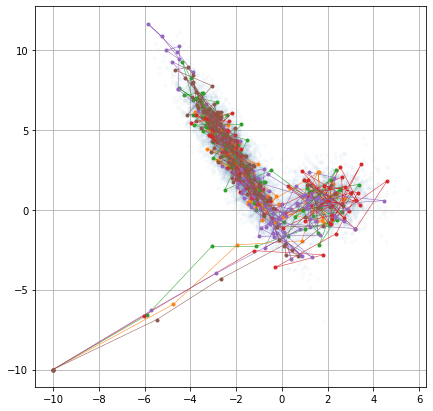

In [6]:
sample_points = mix_dist.sample(10000).numpy()

fig, ax = pp.subplots(figsize=(7, 7))
ax.plot(sample_points[:,0], sample_points[:,1], '.', alpha=0.02)
ax.grid()

for i_chain in range(num_chains):
    cur_chain = np.stack(
        [st.numpy()[i_chain,:] for st in state_list],
        axis=0
    )
    
    ax.plot(cur_chain[:,0], cur_chain[:,1], '.-', linewidth=0.5)

Comparing simple Random Metropolis-Hastings and HMC, one can clearly see that adaptive HMC takes far fewer steps for burn-in.

At the same time however, it does run slower, and seems to be much easier to screw up with incorrect hyperparameters.

## Now use normal sampler with jit-compiled function

In [7]:


@tf.function(autograph=False, jit_compile=True)
def make_rwm_chain(
    num_results: int=3,
    num_burnin_steps: int=1000,
    chain_count: int=5
):
    rwm_kernel = tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=lambda *args: mix_dist.log_prob(*args)
    )
    
    # by initializing correctly can have many chains in parallel
    dim_count = int(mix_dist.event_shape.dims[0])
    init_state = tf.zeros(
        [chain_count, dim_count],
        dtype=np.float32
    )
    
    states = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        kernel=rwm_kernel,
        current_state=init_state,
        trace_fn=None
    )
    
    return states


####


@tf.function(autograph=False, jit_compile=True)
def make_ahmc_chain(
    num_results: int=3,
    num_burnin_steps: int=1000,
    chain_count: int=5
):
    # hmc tends to be sensitive to step, so make it adaptive
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=lambda *args: mix_dist.log_prob(*args),
        step_size=0.02,
        num_leapfrog_steps=10
    )
    #
    adaptive_hmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=10,
        adaptation_rate=0.05
    )
    
    # by initializing correctly can have many chains in parallel
    dim_count = int(mix_dist.event_shape.dims[0])
    init_state = tf.zeros(
        [chain_count, dim_count],
        dtype=np.float32
    )
    
    states = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        kernel=adaptive_hmc_kernel,
        current_state=init_state,
        trace_fn=None
    )
    
    return states

Run and extract results

In [28]:
chain_count = 200
num_burinin_steps=10000
num_results = 50

rwm_states = make_rwm_chain(
    num_burnin_steps=num_burinin_steps,
    num_results=num_results,
    chain_count=chain_count
).numpy()

ahmc_states = make_ahmc_chain(
    num_burnin_steps=num_burinin_steps,
    num_results=num_results,
    chain_count=chain_count
).numpy()

sample_points = mix_dist.sample(chain_count*num_results).numpy()

Text(0.5, 1.0, 'Adaptive HMC')

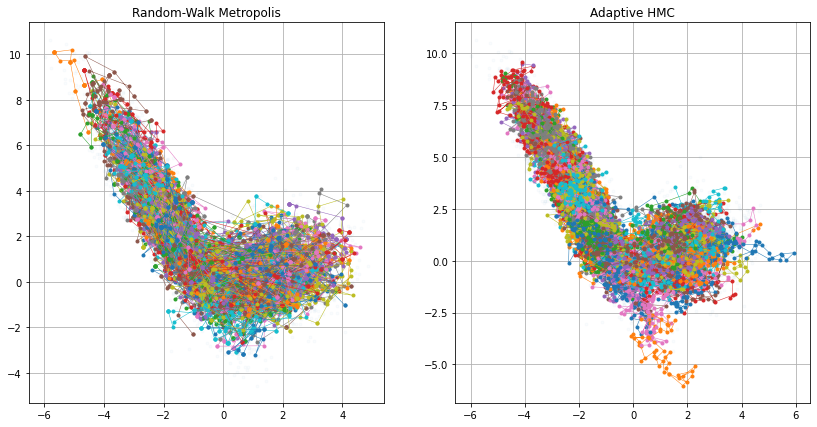

In [29]:
fig, (ax, ax2) = pp.subplots(1, 2, figsize=(14, 7))
#
ax.plot(sample_points[:,0], sample_points[:,1], '.', alpha=0.02)
ax.grid()
#
ax2.plot(sample_points[:,0], sample_points[:,1], '.', alpha=0.02)
ax2.grid()


for i_chain in range(chain_count):
    cur_rwm_chain = rwm_states[:, i_chain, :]
    cur_ahmc_chain = ahmc_states[:, i_chain, :]
    
    ax.plot(cur_rwm_chain[:,0], cur_rwm_chain[:,1], '.-', linewidth=0.5)
    ax2.plot(cur_ahmc_chain[:,0], cur_ahmc_chain[:,1], '.-', linewidth=0.5)
    
#
ax.set_title('Random-Walk Metropolis')
ax2.set_title('Adaptive HMC')

Is there much difference in marginal distributions?

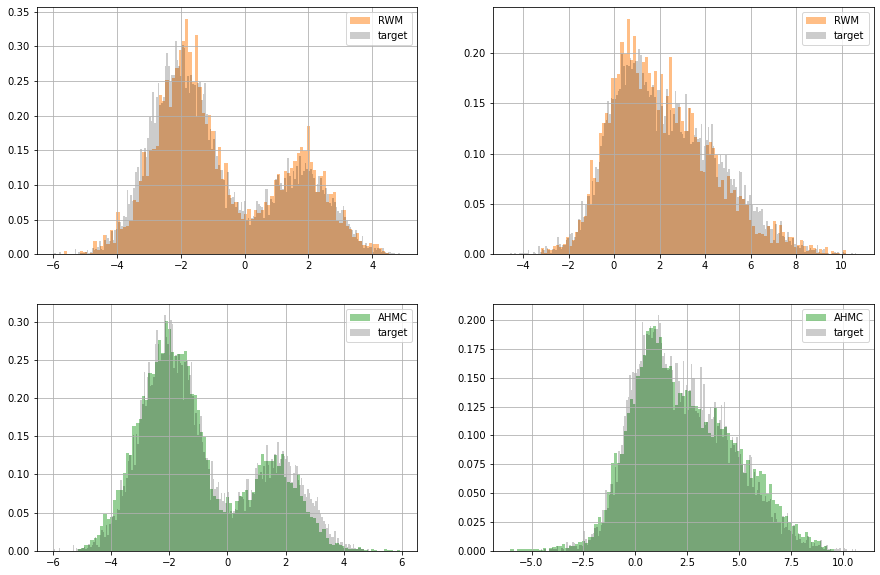

In [30]:
hor_var_rwm = rwm_states[:,:, 0].reshape(-1)
hor_var_ahmc = ahmc_states[:,:, 0].reshape(-1)

vert_var_rwm = rwm_states[:,:, 1].reshape(-1)
vert_var_ahmc = ahmc_states[:,:, 1].reshape(-1)

fig, ((ax1, ax2), (ax3, ax4)) = pp.subplots(2, 2, figsize=(15,10))
#
_ = ax1.hist(hor_var_rwm, bins=100, alpha=0.5, label='RWM', color=cm.tab10(1), density=True)
_ = ax1.hist(sample_points[:,0], bins=200, alpha=0.2, label='target', color='k', density=True)
ax1.grid()
ax1.legend()
#
_ = ax2.hist(vert_var_rwm, bins=100, alpha=0.5, label='RWM', color=cm.tab10(1), density=True)
_ = ax2.hist(sample_points[:,1], bins=200, alpha=0.2, label='target', color='k', density=True)
ax2.grid()
ax2.legend()
#
#
_ = ax3.hist(hor_var_ahmc, bins=100, alpha=0.5, label='AHMC', color=cm.tab10(2), density=True)
_ = ax3.hist(sample_points[:,0], bins=200, alpha=0.2, label='target', color='k', density=True)
ax3.grid()
ax3.legend()
#
_ = ax4.hist(vert_var_ahmc, bins=100, alpha=0.5, label='AHMC', color=cm.tab10(2), density=True)
_ = ax4.hist(sample_points[:,1], bins=200, alpha=0.2, label='target', color='k', density=True)
ax4.grid()
ax4.legend()


Both are RWM and AHMC are not perfect, but not too bad, in different way, compared to target distribution.